In [170]:
import numpy as np
import matplotlib.pyplot as plt

a) Wir bauen zunächst eine Funktion, die das Gleichungssystem, welche in der Aufgabe spezifiziert wurde aufbaut.

In [171]:
def generate_stuff(n) -> tuple:
    A = np.zeros([n,n])
    x = np.ndarray(n)

    for i in range(0,n):
        x[i] = 1
        for j in range(0,n):
            if i == j:
                A[i][j] = 1e-9
            elif i==j+1 or j==i+1:
                A[i][j] = 1
            else:
                A[i][j] = 0

    b = np.matmul(A,x)
    return A, b, x

A, b, x_real = generate_stuff(3)
print("A = \n" + str(A))
print("b = " + str(b))
print("x = " + str(x_real))

A = 
[[1.e-09 1.e+00 0.e+00]
 [1.e+00 1.e-09 1.e+00]
 [0.e+00 1.e+00 1.e-09]]
b = [1. 2. 1.]
x = [1. 1. 1.]


Die LR-Zerlegung ohne Pivotisierung ist relativ selbsterklärend. $L$ und $R$ werden jeweils in A geschrieben, so dass: $$a_{ij} = R$$ für $i \leq j$ und $$a_{ij} = L$$ für $j < i$ sind. Die Zerlegung an sich ist in der Erläuterung der Aufgabe definiert.



In [172]:
def lr_zerlegung_ohne_pivot(A: np.ndarray) -> np.ndarray:
    n = A.shape[0]
    for i in range(0,n-1):
        for k in range(i+1, n):
            if A[k][i] != 0:
                A[k][i] = A[k][i]/A[i][i]
                for j in range(i+1, n):
                    A[k][j] -= A[k][i]*A[i][j]

    return A

A,b,x_real = generate_stuff(3)
print(lr_zerlegung_ohne_pivot(A))

[[ 1.e-09  1.e+00  0.e+00]
 [ 1.e+09 -1.e+09  1.e+00]
 [ 0.e+00 -1.e-09  2.e-09]]


b) Vorwärts- und Rückwärtseinsetzen werden über jeweils zwei Schleifen definiert, welche die Summe aller $a_{ij}y_j$ ausrechnet und dann von $b_j$ subtrahiert. Bzw. beim Rückwärtseinsetzen noch durch den Koeffizienten der jeweiligen Lösung $x_i$ dividiert. Mit $$Ly = b$$$$Ry = x$$ erhält man die Lösung des Gleichungssystems.

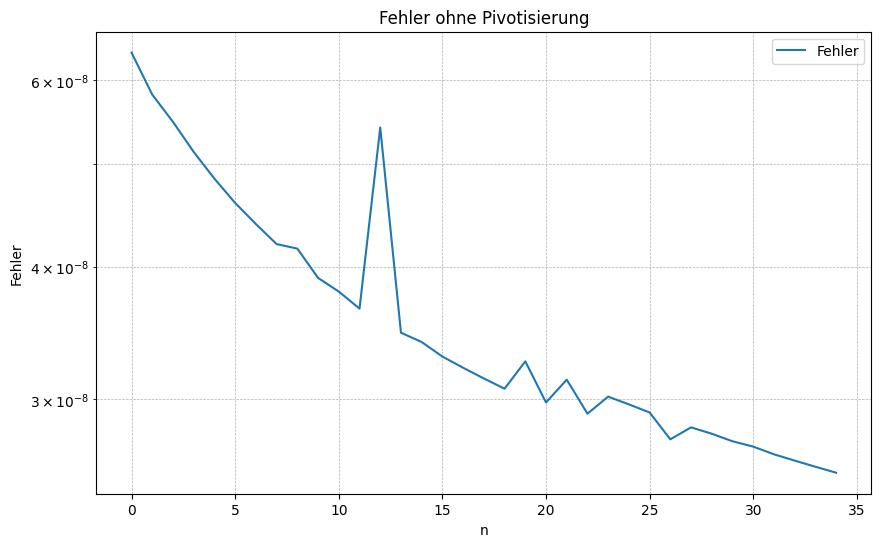

In [173]:
def lr_loeser_ohne_pivot(A, b) -> np.ndarray:
    n = A.shape[0]
    y = np.zeros(n)
    x = np.zeros(n)

    for i in range(0,n):
        sum = 0
        for j in range (0,i):
            sum += A[i][j] * y[j]
        y[i] = b[i] - sum

    for i in range(n-1,-1,-1):
        sum = 0
        for j in range(i+1, n):
            sum += A[i][j]* x[j]
        x[i] = (y[i] - sum) / A[i][i]

    return x


result = np.zeros(35)
for i in range(5, 40):
    A,b,x_real = generate_stuff(i)
    A = lr_zerlegung_ohne_pivot(A)
    x = lr_loeser_ohne_pivot(A, b)
    result[i-5] = np.linalg.norm(x_real-x)/np.linalg.norm(x_real)

plt.figure(figsize=(10, 6))
plt.plot(result, label="Fehler")

plt.xlabel("n")
plt.ylabel("Fehler")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Fehler ohne Pivotisierung")

plt.show()

c) Bei der Pivotisierung wird $\max_{{1 \leq j \leq n}}(|a_{j1}|)$ gesucht und als Pivot ausgewählt, die Zeilenvertauschung wird in einer Permutationsmatrix gespeichert, welche als Liste implementiert wird (auch hier lässt sich das Gott sei Dank durch Python einfach implementieren). Schlussendlich wird die Permutationsreihenfolge zurückgegeben.

In [174]:
def lr_zerlegung_mit_pivot(A: np.ndarray) -> np.ndarray:
    n = A.shape[0]
    p = np.arange(n)
    for i in range(0,n):
        max = np.argmax(np.abs(A[i:n,i])) + i

        if max != i:
            A[[i,max], :] = A[[max,i], :]
            p[i],p[max] = p[max], p[i]

        for j in range(i+1,n):
            if A[i,i] != 0:
                A[j,i] = A[j,i] / A[i,i]
                A[j,i+1:] -= A[j,i] * A[i,i+1:]

    return p

A,b,x = generate_stuff(3)
print(A)
print(lr_zerlegung_mit_pivot(A))

[[1.e-09 1.e+00 0.e+00]
 [1.e+00 1.e-09 1.e+00]
 [0.e+00 1.e+00 1.e-09]]
[1 0 2]


d) Nun wird die Lösung implementiert. Diese ist sehr ähnlich zum Lösungsverfahren ohne Pivotisierung, mit dem Unterschied, dass $b$ mit der Permutationsmatrix $P$ multipliziert wird, die wir als Liste implementiert haben. Danach wird das Gleichungssystem mit Vorwärts- und Rückwärtseinsetzen gelöst. Der Fehler ist hierbei wesentlich instabiler, als bei der Implementierung ohne Pivotisierung, gelegentlich ist er höher oder sehr niedriger, als ohne Pivotisierung.

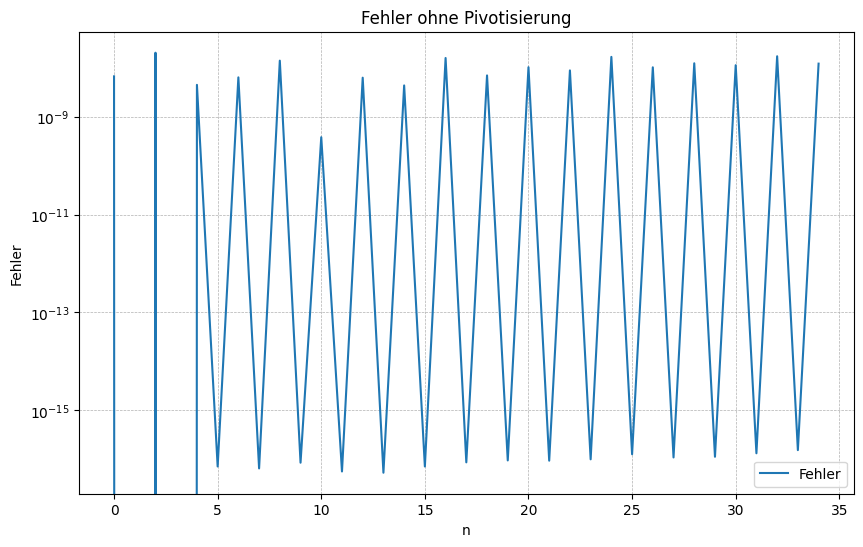

In [175]:
def lr_loeser_mit_pivot(p: np.ndarray, A: np.ndarray, b: np.ndarray) -> np.ndarray:
    n = A.shape[0]
    b_perm = b[p]
    y = np.ndarray(n)
    x = np.ndarray(n)

    for i in range(0,n):
        sum = 0
        for j in range (0,i):
            sum += A[i][j] * y[j]
        y[i] = b_perm[i] - sum

    for i in range(n-1,-1,-1):
        sum = 0
        for j in range(i+1, n):
            sum += A[i][j]* x[j]
        x[i] = (y[i] - sum) / A[i][i]

    return x


result = np.zeros(35)
for i in range(5, 40):
    A,b,x_real = generate_stuff(i)
    p = lr_zerlegung_mit_pivot(A)
    x = lr_loeser_mit_pivot(p, A, b)
    result[i-5] = np.linalg.norm(x_real-x)/np.linalg.norm(x_real)

plt.figure(figsize=(10, 6))
plt.plot(result, label="Fehler")

plt.xlabel("n")
plt.ylabel("Fehler")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Fehler ohne Pivotisierung")

plt.show()